In [1]:
from stanford_cs229.modeling.softmax import SoftmaxRegression
from stanford_cs229.modeling.k_means import KMeans
from stanford_cs229.modeling.perceptron import train_perceptron, predict_perceptron
from stanford_cs229.utils.util import load_our_data, plot, preprocess_rolling_avg, cmap
from stanford_cs229.utils.csv_plotter_classifier import format_data

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
reload(plt)
%matplotlib notebook

# Number of class for learning
K = 5
plt_counter = 0

# Load data and preprocess for K-means
raw_data = load_our_data('stanford_cs229/data/ydeskx_overhand_weight_4-60Hz_extended2.csv')
raw_data = raw_data / raw_data.max()
X_tr = preprocess_rolling_avg(raw_data)
X_tr = X_tr / X_tr.max()

shuffler = np.random.permutation(raw_data.shape[0])
X_tr = X_tr[shuffler]
raw_data = raw_data[shuffler]


# Run K-means to get labels
print("** Running K-means to label raw data **")
k_means = KMeans(verbose=True)
Y_tr_k_means = k_means.assign(X_tr, K, random=True)

** Running K-means to label raw data **
Iteration: 1, Loss: 440.2507177982077
Iteration: 2, Loss: 243.4566082845738
Iteration: 3, Loss: 191.45600579091095
Iteration: 4, Loss: 177.94388213823274
Iteration: 5, Loss: 174.40357190042064
Iteration: 6, Loss: 173.68603314177057
Iteration: 7, Loss: 173.47216793489577
Iteration: 8, Loss: 173.39067668832988
Iteration: 9, Loss: 173.34338445852083
Iteration: 10, Loss: 173.3364085889764
Iteration: 11, Loss: 173.33548813867932
Iteration: 12, Loss: 173.33518671806675
Iteration: 13, Loss: 173.33518671806675
Time: 0:00:09.952958


<IPython.core.display.Javascript object>


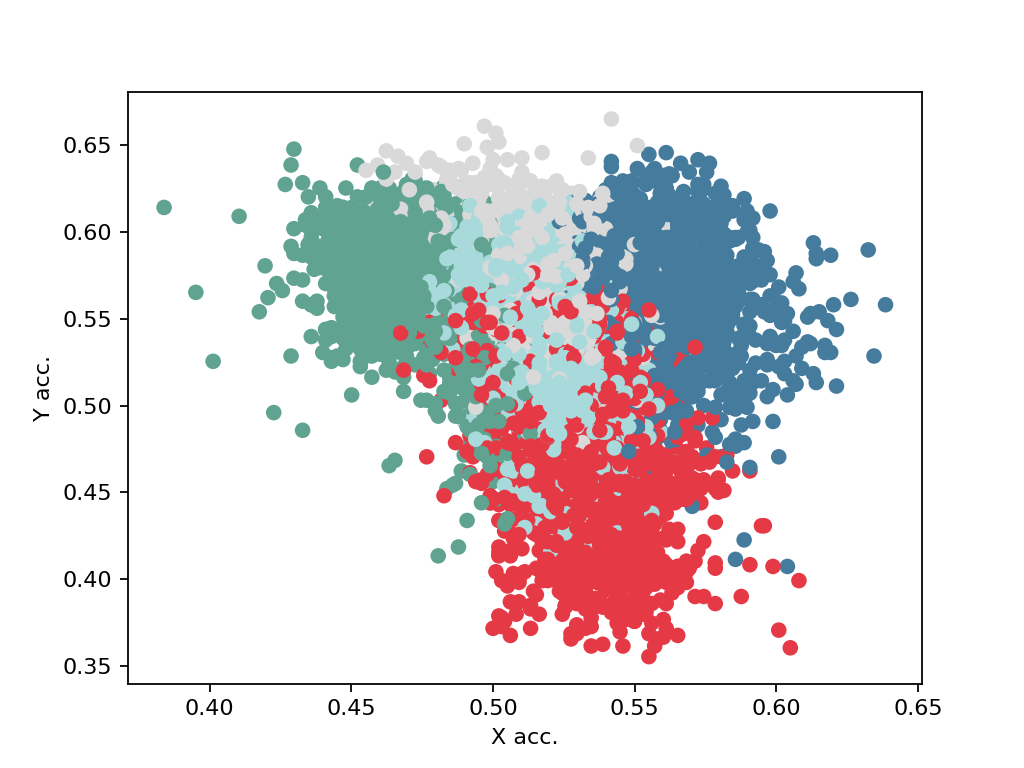

<IPython.core.display.Javascript object>


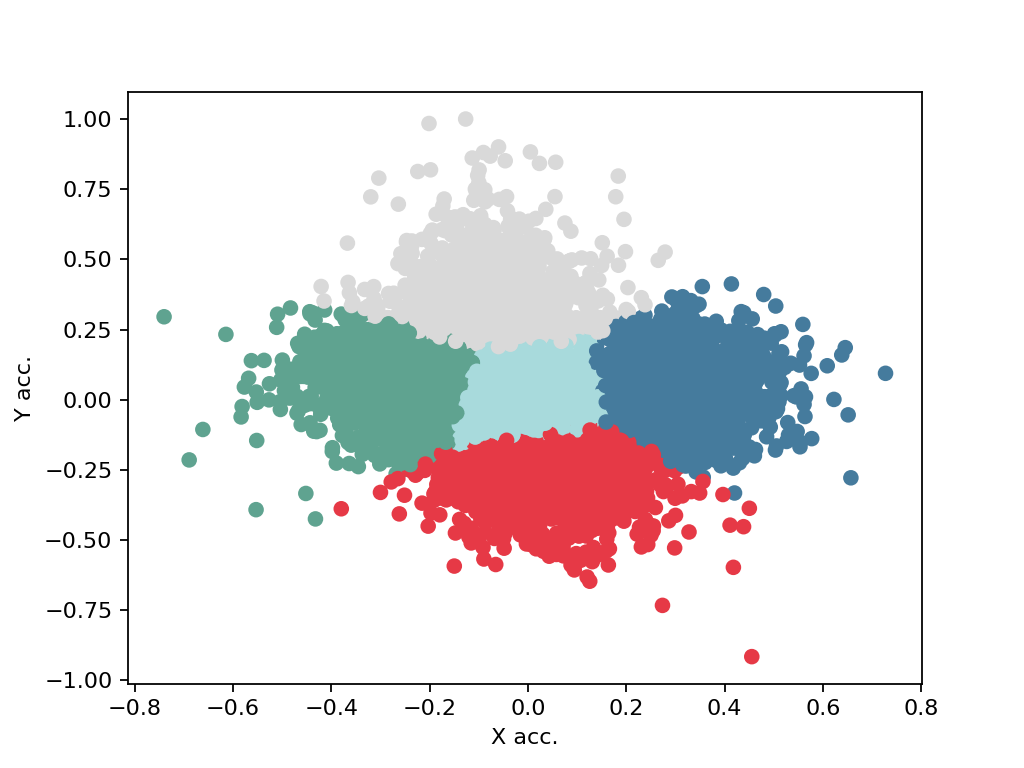

Text(0, 0.5, 'Y acc.')

In [2]:
# Plot raw data
fig1 = plt.figure(plt_counter)
plt_counter += 1
ax1 = plt.axes()
ax1.scatter(raw_data[:,0], raw_data[:,1], c=cmap(Y_tr_k_means))
ax1.set_xlabel('X acc.')
ax1.set_ylabel('Y acc.')

# Plot preprocessed data
fig2 = plt.figure(plt_counter)
plt_counter += 1
ax2 = plt.axes()
ax2.scatter(X_tr[:,0], X_tr[:,1], c=cmap(Y_tr_k_means))
ax2.set_xlabel('X acc.')
ax2.set_ylabel('Y acc.')

In [3]:
# Save plots
save_new_plots = False

if save_new_plots:
  plt.figure(fig1.number)
  plt.savefig('manual_labeling.png', dpi=300)
  plt.figure(fig2.number)
  plt.savefig('k_means_labeling.png', dpi=300)

In [4]:
# Train softmax classifier and make predictions
softmax = SoftmaxRegression(lr=0.01, max_iter=1000, verbose=False)

print('** Training softmax classifier **')
softmax.train(X_tr, Y_tr_k_means, K)

print('** Making predictions **')
Y_pred = softmax.predict(X_tr)

accuracy = np.sum(Y_pred == Y_tr_k_means) / Y_tr_k_means.size
print(accuracy)

** Training softmax classifier **
Training Time: 0:00:00.848066
** Making predictions **
0.5071666666666667


<IPython.core.display.Javascript object>


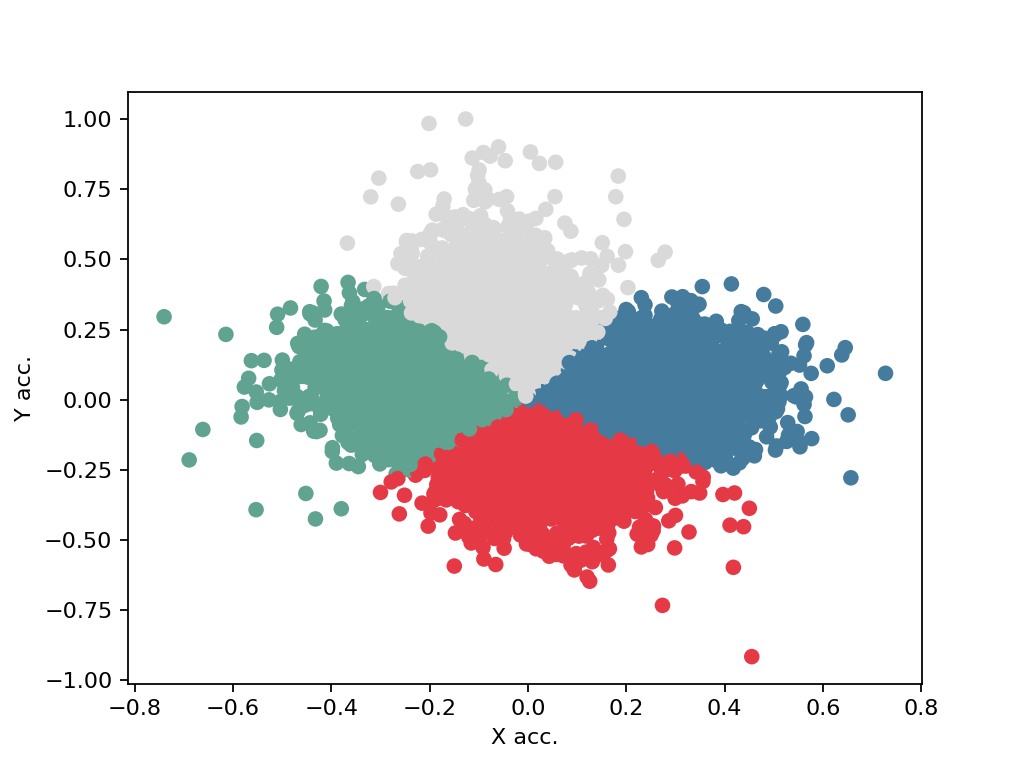

Text(0, 0.5, 'Y acc.')

In [5]:
# Plot data with predicted labels
fig3 = plt.figure(plt_counter)
plt_counter += 1
ax3 = plt.axes()
ax3.scatter(X_tr[:,0], X_tr[:,1], c=cmap(Y_pred))
ax3.set_xlabel('X acc.')
ax3.set_ylabel('Y acc.')

** Training softmax classifier **
Training Time: 0:00:00.879641
** Training softmax classifier **
Training Time: 0:00:01.003877
** Training softmax classifier **
Training Time: 0:00:00.892978
** Training softmax classifier **
Training Time: 0:00:00.922051
** Training perceptron **
Completed 0 iterations
Completed 1000 iterations
** Predicting perceptron **
** Making predictions **


<IPython.core.display.Javascript object>


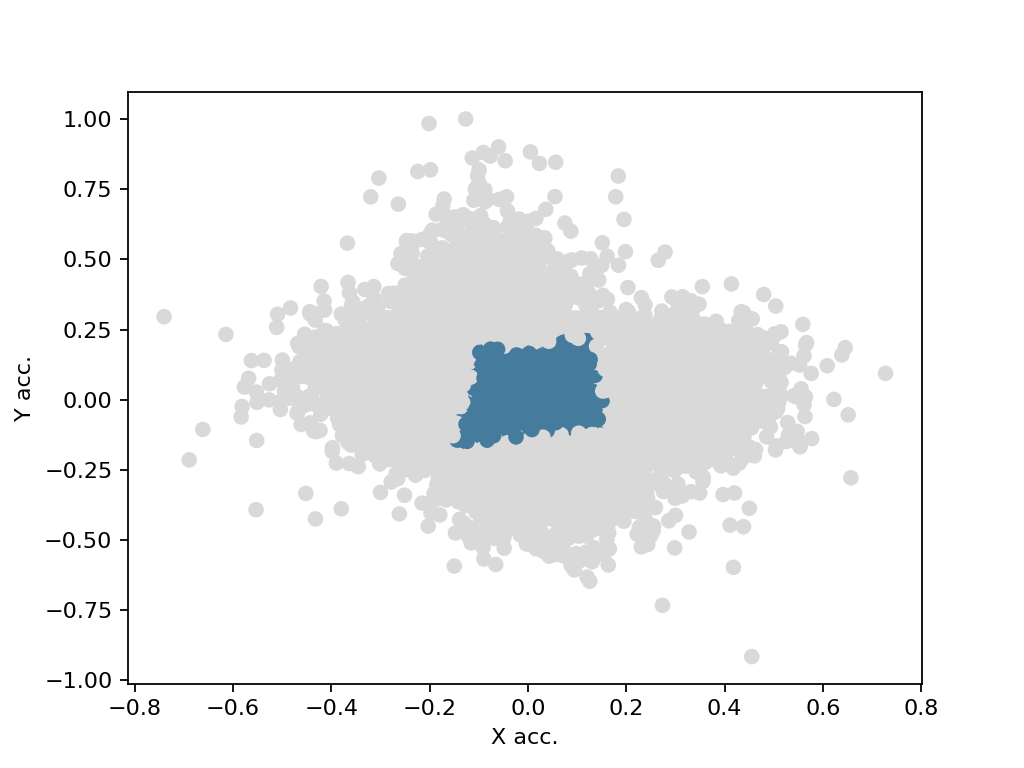

<IPython.core.display.Javascript object>


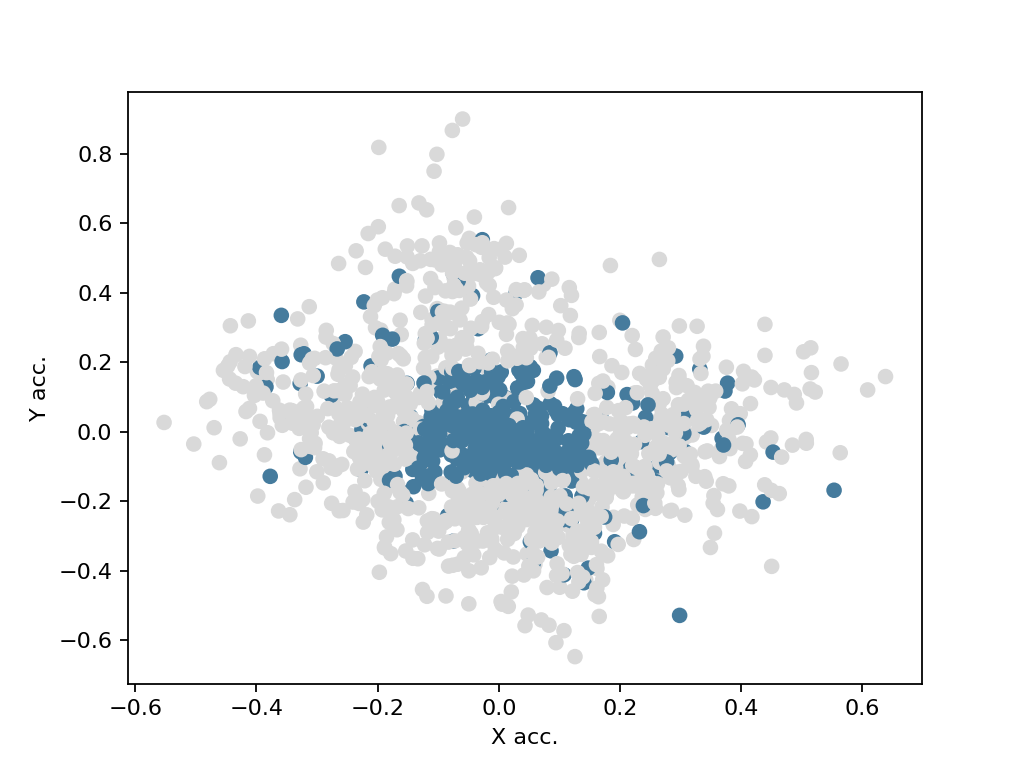

<IPython.core.display.Javascript object>


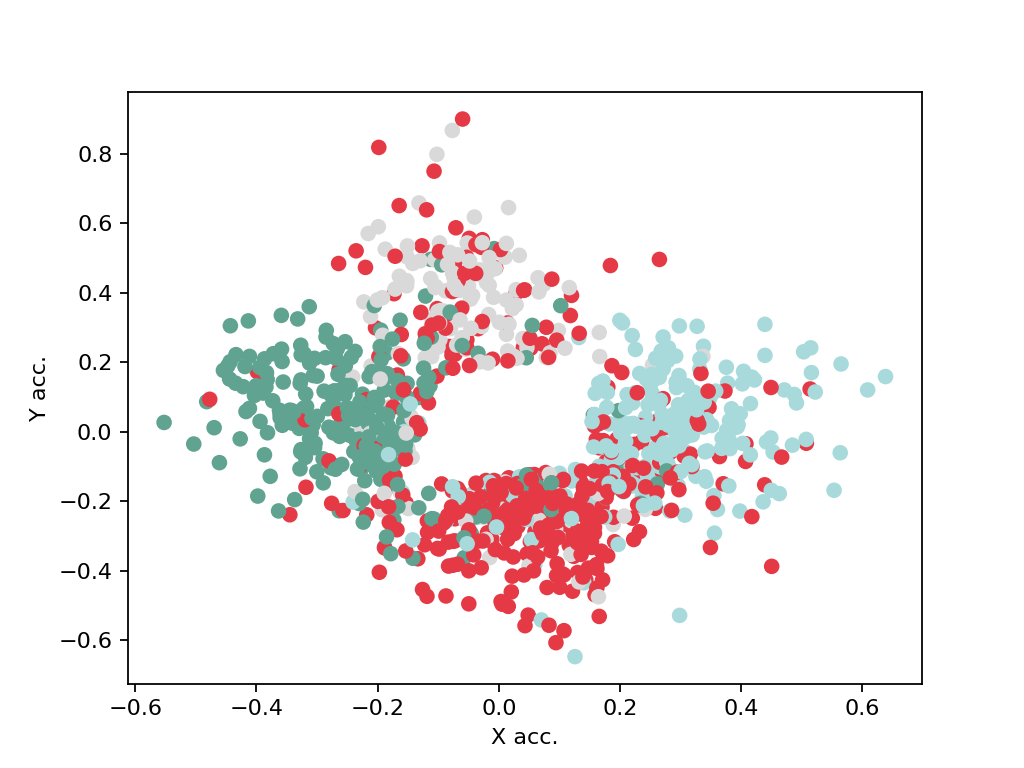

0.6989748369058714


In [9]:
from stanford_cs229.modeling.perceptron import train_perceptron, predict_perceptron

def get_neutral_class():
  for c in np.unique(Y_tr_k_means):
    if c not in np.unique(Y_pred):
      return c

neutral_class = get_neutral_class()
Y_tr_perceptron = np.where(Y_tr_k_means==neutral_class, 0, 1)

# Make neutral class have 0 label by swapping labels with whatever class has the 0 label
Y_pred = np.where(Y_pred==0, neutral_class, Y_pred)

# Make neutral class have 0 label by swapping labels with whatever class has the 0 label
k_means_zeros = np.argwhere(Y_tr_k_means == 0)
k_means_neutral_class = np.argwhere(Y_tr_k_means == neutral_class)
Y_tr_k_means[k_means_zeros] = neutral_class
Y_tr_k_means[k_means_neutral_class] = 0

radius = 0.05

NUM_DATA = 2000

# Train softmax classifier and make predictions
softmax_2 = SoftmaxRegression(lr=0.005, max_iter=5000, verbose=False)

for i in range(4):
  shuffler = np.random.permutation(raw_data.shape[0])
  Y_pred = Y_pred[shuffler]
  X_tr = X_tr[shuffler]
  raw_data = raw_data[shuffler]
  Y_tr_perceptron = Y_tr_perceptron[shuffler]
  nonzero_indices = np.nonzero(Y_tr_perceptron[:NUM_DATA])
  Y_tr_k_means = Y_tr_k_means[shuffler]
  
  softmax_tr_y = Y_pred[:NUM_DATA][nonzero_indices]-1
  softmax_tr_x = raw_data[:NUM_DATA, 2:]
  print('** Training softmax classifier **')
  softmax_2.train(softmax_tr_x[nonzero_indices], softmax_tr_y, K-1)
print('** Training perceptron **')
state = train_perceptron(raw_data[:NUM_DATA, 2:] * 10, Y_tr_perceptron[:NUM_DATA], radius=radius)
  
print('** Predicting perceptron **')
predictions = np.array([predict_perceptron(state, raw_data[i, 2:] * 10, radius=radius) for i in range(NUM_DATA)])

print('** Making predictions **')
Y_pred_2 = softmax_2.predict(softmax_tr_x) + 1

# Plot data with predicted labels
fig5 = plt.figure(plt_counter)
plt_counter += 1
ax5 = plt.axes()
ax5.scatter(X_tr[:,0], X_tr[:,1], c=cmap(Y_tr_perceptron))
ax5.set_xlabel('X acc.')
ax5.set_ylabel('Y acc.')

# Plot data with predicted labels
fig6 = plt.figure(plt_counter)
plt_counter += 1
ax6 = plt.axes()
ax6.scatter(X_tr[:NUM_DATA,0], X_tr[:NUM_DATA,1], c=cmap(predictions))
ax6.set_xlabel('X acc.')
ax6.set_ylabel('Y acc.')

# Plot data with predicted labels
fig4 = plt.figure(plt_counter)
plt_counter += 1
ax4 = plt.axes()
ax4.scatter(X_tr[:NUM_DATA,0][nonzero_indices], X_tr[:NUM_DATA,1][nonzero_indices], c=cmap(Y_pred_2[nonzero_indices]))
ax4.set_xlabel('X acc.')
ax4.set_ylabel('Y acc.')

accuracy_2 = np.sum(Y_pred_2[nonzero_indices] == Y_pred[:NUM_DATA][nonzero_indices]) / Y_pred[:NUM_DATA][nonzero_indices].size
print(accuracy_2)

<IPython.core.display.Javascript object>


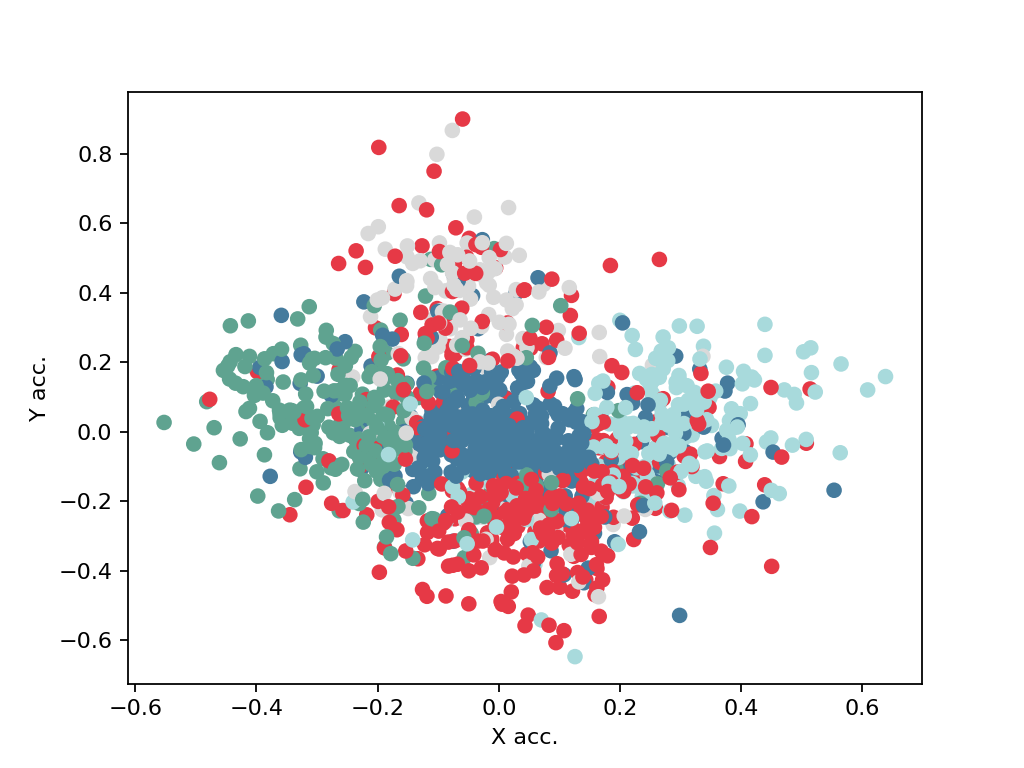

<IPython.core.display.Javascript object>


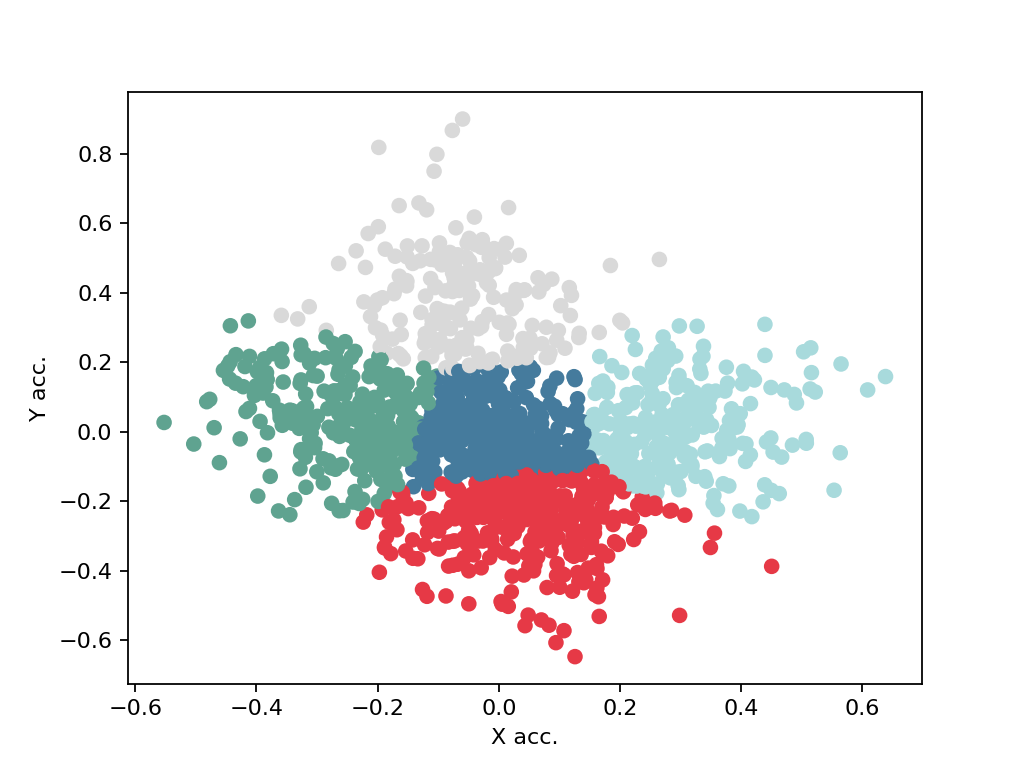

Text(0, 0.5, 'Y acc.')

In [10]:
# Plot data with predicted labels
fig7 = plt.figure(plt_counter)
plt_counter += 1
ax7 = plt.axes()
ax7.scatter(X_tr[:NUM_DATA,0], X_tr[:NUM_DATA,1], c=cmap(Y_pred_2 * predictions))
ax7.set_xlabel('X acc.')
ax7.set_ylabel('Y acc.')

# Plot data with predicted labels
fig8 = plt.figure(plt_counter)
plt_counter += 1
ax8 = plt.axes()
ax8.scatter(X_tr[:NUM_DATA,0], X_tr[:NUM_DATA,1], c=cmap(Y_tr_k_means[:NUM_DATA]))
ax8.set_xlabel('X acc.')
ax8.set_ylabel('Y acc.')

In [11]:
# Determine what percent of the data each class makes up
for c in np.unique(Y_tr_k_means[:NUM_DATA]):
  percent_makup = np.sum(Y_tr_k_means[:NUM_DATA] == c) / Y_tr_k_means[:NUM_DATA].size
  print('Percent makup of total data for class {}: {}'.format(c, percent_makup))

# Determine the accuracy on each individual class
labels_for_incorrect_predictions = np.where(Y_tr_k_means[:NUM_DATA] != Y_pred_2 * predictions, Y_tr_k_means[:NUM_DATA], -1)
labels_for_incorrect_predictions = labels_for_incorrect_predictions[labels_for_incorrect_predictions >= 0]
for c in np.unique(Y_tr_k_means[:NUM_DATA]):
  percent_makup = np.sum(labels_for_incorrect_predictions == c) / labels_for_incorrect_predictions.size
  print('Percent makup of incorrect predictions for class {}: {}'.format(c, percent_makup))

Percent makup of total data for class 0: 0.4635
Percent makup of total data for class 1: 0.099
Percent makup of total data for class 2: 0.1215
Percent makup of total data for class 3: 0.1345
Percent makup of total data for class 4: 0.1815
Percent makup of incorrect predictions for class 0: 0.08295964125560538
Percent makup of incorrect predictions for class 1: 0.23318385650224216
Percent makup of incorrect predictions for class 2: 0.2062780269058296
Percent makup of incorrect predictions for class 3: 0.17488789237668162
Percent makup of incorrect predictions for class 4: 0.30269058295964124


In [12]:
accuracy_3 = np.sum(Y_pred_2 * predictions == Y_tr_k_means[:NUM_DATA]) / Y_tr_k_means[:NUM_DATA].size
print(accuracy_3)

0.777
